# IMU-Based Human Activity Recognition  
## Model Development and Evaluation

This notebook trains, evaluates, and saves a machine learning model using
feature-engineered IMU datasets generated in the previous stage.


## 1. Import Required Libraries



In [1]:
#numerical computation
import numpy as np

#data handling
import pandas as pd

#utility
import os

#model saving
import joblib

#model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from six import StringIO
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
import m2cgen as m2c


## 2. Load Feature-Engineered Datasets

Feature CSV files generated during feature engineering are loaded and combined
to form the final training dataset.


In [2]:
FEATURED_PATH = "../data/Featured data"

# List all featured CSV files
feature_files = sorted(os.listdir(FEATURED_PATH))

# Extract activity names from filenames
activity_names = [f.replace("_features.csv", "") for f in feature_files]

# Create activity ↔ label mapping
activity_map = {act: idx for idx, act in enumerate(activity_names)}
label_map = {idx: act for act, idx in activity_map.items()}

activity_map


{'brisk walking': 0,
 'cycling': 1,
 'eating': 2,
 'jogging': 3,
 'phone interaction': 4,
 'pick and place': 5,
 'sit-stand-sit': 6,
 'sitting': 7,
 'stair-down': 8,
 'stair-up': 9,
 'standing': 10,
 'walking': 11}

label_map = {
    0: "Sitting",
    1: "Standing",
    2: "Walking",
    3: "Brisk Walking",
    4: "Jogging",
    5: "Cycling",
    6: "Stair Up",
    7: "Stair Down",
    8: "Sit-Stand-Sit",
    9: "Phone Interaction",
    10: "Eating with Spoon",
    11: "Pick and Place"
}

## 3. Dataset Construction


In [3]:
X_all = []
y_all = []

for act in activity_names:
    df = pd.read_csv(os.path.join(FEATURED_PATH, f"{act}_features.csv"))
    
    X_all.append(df.values)
    y_all.extend([activity_map[act]] * len(df))

X_all = np.vstack(X_all)
y_all = np.array(y_all)

print("Feature matrix shape:", X_all.shape)
print("Label vector shape:", y_all.shape)


Feature matrix shape: (10788, 66)
Label vector shape: (10788,)


## 4. Train–Test Split


In [4]:
X_train, X_test,y_train,y_test=train_test_split(
    X_all,y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all
)

## 5. Model Training


In [5]:
model=DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current 

In [6]:
model_code = m2c.export_to_python(model)
print(model_code)

def score(input):
    if input[7] <= -1.0925300121307373:
        if input[56] <= -28.140259742736816:
            var0 = [0.3996188055908513, 0.0, 0.0, 0.6003811944091487, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
            var0 = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    else:
        if input[32] <= 0.02191099990159273:
            if input[18] <= -0.8925780057907104:
                var0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
            else:
                if input[31] <= 0.44359853863716125:
                    if input[59] <= 0.48759739100933075:
                        var0 = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                    else:
                        var0 = [0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
                else:
                    var0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        else:
            if input[13] <= 0.7241517603397

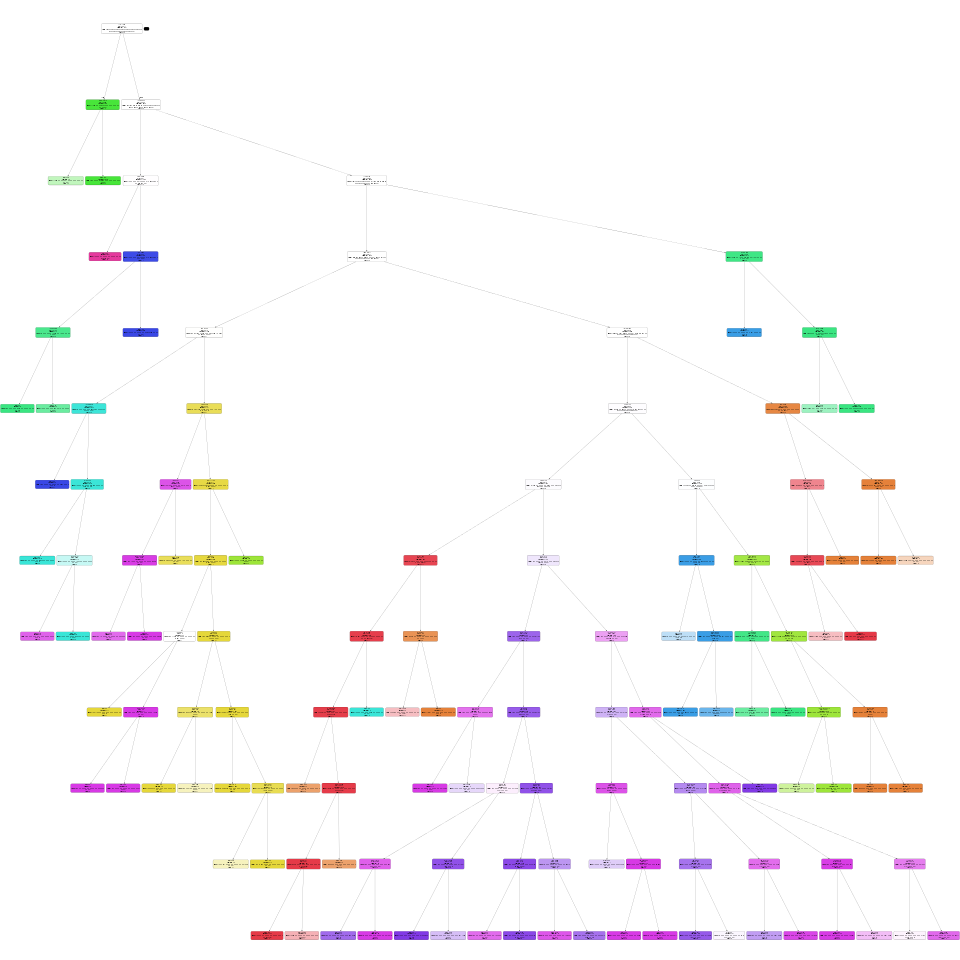

In [9]:
dot_data = StringIO()

export_graphviz(
    model,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=[f"f{i}" for i in range(model.n_features_in_)],
    class_names=[str(i) for i in model.classes_]
)

# create graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# force a square layout
graph.set_size('"10,10!"')     # square window
graph.set_ratio('fill')        # fill the square
graph.set_rankdir('TB')        # top-to-bottom (default, clearer)


graph.write_jpg("../results/decision_tree.jpg")
Image(graph.create_png())


## 6. Model Evaluation


### Confusion Matrix

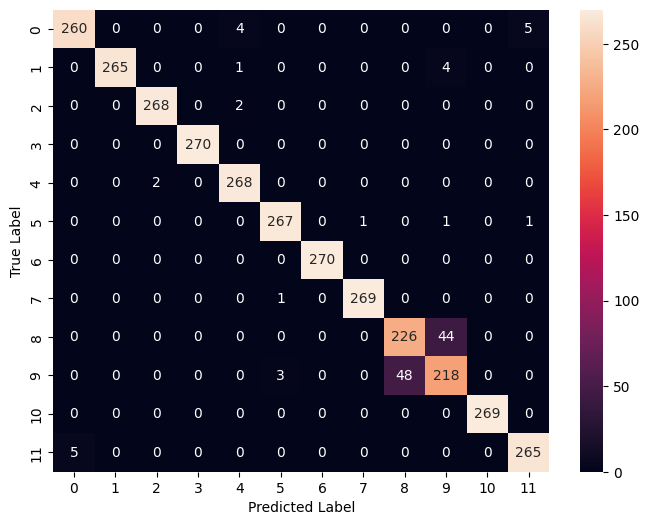

In [11]:
y_pred=model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
dpi=300
plt.savefig("../results/Confusion_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Accuracy score

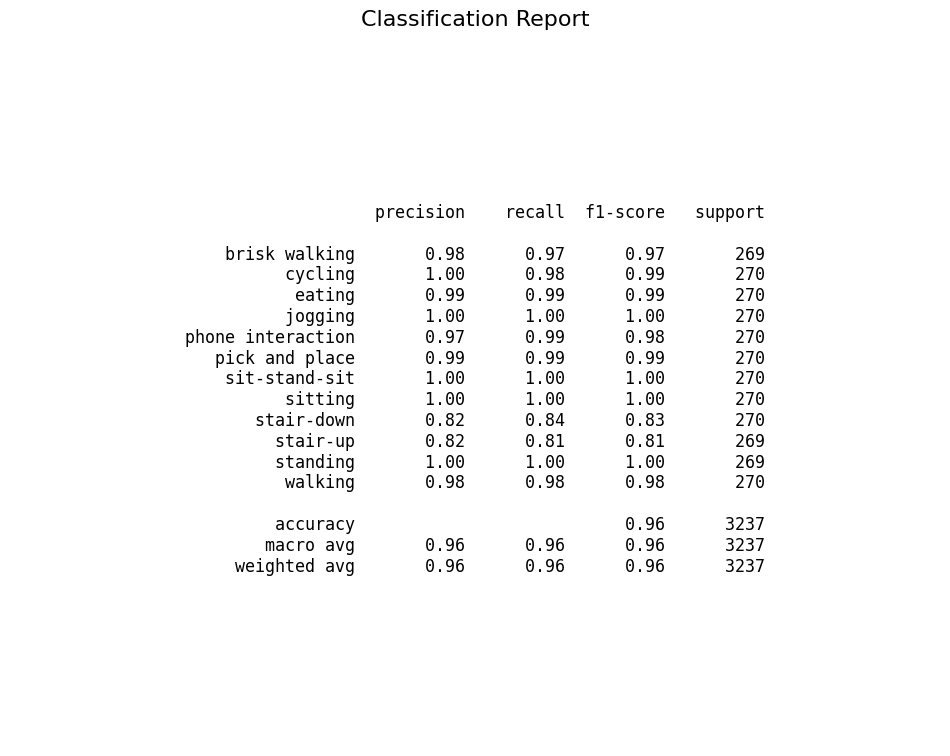

In [16]:
report = classification_report(y_test, y_pred, target_names=list(label_map.values()))

plt.figure(figsize=(12, 9))

plt.text(
    0.5, 0.5, report,
    fontsize=12,
    family="monospace",
    ha="center",
    va="center",
    transform=plt.gca().transAxes
)

plt.axis("off")
plt.title("Classification Report", fontsize=16, pad=20)

plt.savefig("../results/Classification_Report.png", dpi=300, bbox_inches="tight")
plt.show()

### Feature Importance Analysis


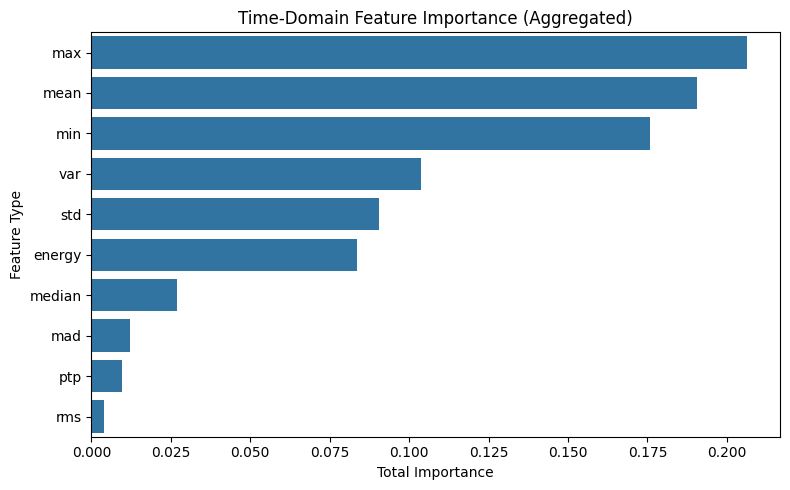

FileNotFoundError: [Errno 2] No such file or directory: '..results/important_features.jpg'

<Figure size 640x480 with 0 Axes>

In [17]:
feature_cols=['mean','min','max','std','var','rms','ptp','median','mad','energy']
importances = model.feature_importances_
time_feature_importances = importances[6:]   
# 10 feature types × 6 channels
time_feature_importances = time_feature_importances.reshape(len(feature_cols), 6)

# Sum across channels
feature_type_importance = time_feature_importances.sum(axis=1)

feat_type_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": feature_type_importance
}).sort_values("importance", ascending=False)

feat_type_imp

plt.figure(figsize=(8,5))
sns.barplot(
    data=feat_type_imp,
    x="importance",
    y="feature"
)

plt.title("Time-Domain Feature Importance (Aggregated)")
plt.xlabel("Total Importance")
plt.ylabel("Feature Type")
plt.tight_layout()
plt.show()
plt.savefig("..results/important_features.jpg", dpi=300, bbox_inches="tight")


## 7. Save Trained Model and Label Map


In [18]:
# Create deployment directory if needed
DEPLOY_PATH = "../deployment"
os.makedirs(DEPLOY_PATH, exist_ok=True)

# Save trained model
joblib.dump(model, os.path.join(DEPLOY_PATH, "activity_model.pkl"))

# Save label map for deployment
import json
with open(os.path.join(DEPLOY_PATH, "label_map.json"), "w") as f:
    json.dump(label_map, f)

print("Model and label map saved successfully.")


Model and label map saved successfully.


## 8. Summary

- Feature-engineered datasets were used to train a Decision Tree classifier
- The model achieved strong classification performance across activities
- The trained model and label map were saved for real-time deployment
